In [1]:
import sys
sys.path.append('..')
# from src.evo_eq_model import *
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import re
import neo_originations.utils as ut
import neo_originations.plot_utils as put

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so
import scipy.stats as spst

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
sns.set_theme(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

2024-12-10 17:01:09.969 | INFO     | neo_originations.config:<module>:11 - PROJ_ROOT path is: /Users/dennytrimcev/Dropbox/Work_Main/Thesis/2_chapter


In [3]:
from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
flupredict_to_pango = {"1":"WT",
            "1A":"A",
            "1B":"B",
            "1C":"B.1",
            "1C.2A":"B.1",
            "1C.2A.3A":"B.1",
            "1C.2A.3A.4A":"B.1.427/429",
            "1C.2A.3A.4B":"B.1.351",
            '1C.2A.3A.4C':"B.1.526",
            "1C.2B":"B1.1",
            "1C.2B.3D":"B.1.1.7",
            "1C.2B.3G":"P.1",
            "1C.2B.3J":"BA",
            "1C.2B.3J.4D":"BA.1",
            "1C.2B.3J.4D.5A":"BA.1.1",
            "1C.2B.3J.4E":"BA.2",
            "1C.2B.3J.4E.5B": "BA.2.12.1",
            "1C.2B.3J.4E.5C":"BA.2.75",
            "1C.2B.3J.4E.5C.6A":"BA.2.75.2",
            "1C.2B.3J.4E.5C.6E":"BM.1.1",
            "1C.2B.3J.4E.5C.6I.7C":"CH.1.1",
            "1C.2B.3J.4E.5C.6F":"BN.1",
            "1C.2B.3J.4E.5O":"BA.2.86",
            "1C.2B.3J.4E.5O.6L":"JN.1",
            "1C.2B.3J.4E.5O.6L.7G":"JN.1.1",
            "1C.2B.3J.4E.5O.6L.7H":"JN.1.4",
            "1C.2B.3J.4E.5O.6L.7I":"JN.1.11",
            "1C.2B.3J.4F":"BA.4",
            "1C.2B.3J.4F.5D":"BA.4.6",
            "1C.2B.3J.4G":"BA.5",
            "1C.2B.3J.4G.5E":"BF.7",
            "1C.2B.3J.4G.5F":"BQ.1",
            "1C.2B.3J.4G.5F.6B":"BQ.1.1",
            "1C.2C":"B.1.177",
            "1C.2D":"B.1.1",
            "1C.2D.3E":"B.1.617.1",
            "1C.2D.3F":"B.1.617.2",
            "1C.2A.3I":"B.1.621",
            "1C.2B.3J.4E.5N":"XBB",
            "1C.2B.3J.4E.5N.6J":"XBB.1.5",
            "1C.2B.3J.4E.5N.6J.7F":"JD.1.1",
            "1C.2B.3J.4E.5N.6J.7D":"XBB.1.9",
            "1C.2B.3J.4E.5N.6J.7D.8A":"EG.5.1",
            "1C.2B.3J.4E.5N.6J.7D.8A.9A":"HK.3",
            "1C.2B.3J.4E.5N.6J.7D.8A.9B":"HV.1",
            "1C.2B.3J.4E.5N.6J.7E":"XBB.1.16",
            "1C.2B.3J.4E.5N.6K":"XBB.2.3"}

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

output_folder= project_path+'/reports/figures/'
os.makedirs(output_folder, exist_ok = True)
data_folder = project_path+'/data/'
saves_folder= project_path + '/data/interim/'
self_generated_data = project_path + '/data/processed/'


In [6]:
syn_gene_info = pd.read_feather(saves_folder+'2024-08-saves/syn_gene_info.feather')

In [7]:
# global_clade_stats_SARS_CoV_2_folder = project_path+'/data/global_clade_stats_SARS_CoV_2/'
global_clade_stats_SARS_CoV_2_folder = project_path+'/data/external/2024-07-15-data/'

assert os.path.exists(global_clade_stats_SARS_CoV_2_folder)

global_clade_statistics_SARS_CoV_2_World = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

global_clade_statistics_SARS_CoV_2_World = global_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

driver_mutation_statistics = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')


reference_date = pd.to_datetime('2020-01-01')
global_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(global_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

In [8]:
last_date = '2022-12-31'
#/Users/dennytrimcev/Dropbox/Work_Main/neo_originations/data/external/2024-03-04-data
covid_data = pd.read_csv(project_path+'/data/external/2024-03-04-data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World']#.query(f'date < "{last_date}"')

covid_data_World['day_diff'] = (pd.to_datetime(covid_data_World['date']) - reference_date).dt.days

In [9]:
driver_mutation_statistics['Pango_Variant'] = driver_mutation_statistics['Variant'].map(flupredict_to_pango)

syn_set = set([c for c in driver_mutation_statistics.columns if 'syn' in c]) - set([c for c in driver_mutation_statistics.columns if 'RBD' in c or 'weight' in c])
nonsyn_set = [c.split('_')[1] for c in syn_set if 'syn' in c]

driver_mutation_statistics['syn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in syn_set]), axis=1)
driver_mutation_statistics['nonsyn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in nonsyn_set]), axis=1)
driver_mutation_statistics['total_weight'] = driver_mutation_statistics.apply(lambda x: x['syn_weight']+x['nonsyn_weight'], axis=1)

In [10]:
L_syn = 1e4

global_clade_statistics_SARS_CoV_2_World = pd.merge(global_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics[['Clade','syn_weight','total_weight', 'nonsyn_weight', 'S_RBD', 'Pango_Variant']], on = 'Clade', how = 'left')

global_clade_statistics_SARS_CoV_2_World['local_diversity'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*(1-global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq'])*(global_clade_statistics_SARS_CoV_2_World['syn_weight'])

global_clade_statistics_SARS_CoV_2_World['total_local_diversity'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*(1-global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq'])*(global_clade_statistics_SARS_CoV_2_World['total_weight'])

global_clade_statistics_SARS_CoV_2_World['weighted_freq'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*global_clade_statistics_SARS_CoV_2_World['syn_weight']

average_diversity = global_clade_statistics_SARS_CoV_2_World.groupby('day_diff').agg({'local_diversity':'sum', 'weighted_freq':'sum', 'total_local_diversity':'sum'}).reset_index()
average_diversity['diversity'] = average_diversity['local_diversity']/L_syn
average_diversity['total_diversity'] = average_diversity['total_local_diversity']/3e4
average_diversity['avg_freq'] = average_diversity['weighted_freq']/L_syn

In [11]:
# newest_save_folder= project_path + '/saves/2024-08-19_saves/'

In [12]:
variant_target_folder = saves_folder + '/2024-08-19_saves'
os.listdir(variant_target_folder)
#check if a number is present in the string
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)


i_to_pango_var = {'1': 'WT',
 '3235': 'B.1.351',
 '3561': 'B.1.617.2',
 '3802': 'P.1',
 '5153': 'B.1.1.7',
 '10113': 'BA',
 '29965': 'BA.1',
 '41596': 'BA.2',
 '50393': 'BA.5',
 '63869': 'XBB.1.5',
 '67603': 'XBB',
 '108250': 'XBB.2.3',
 '112635': 'XBB.1.9',
 '126775': 'XBB.1.16',
 '134606': 'EG.5.1'}


div_var_dict = {}
for f in sorted(os.listdir(variant_target_folder)):
    if hasNumbers(f) and 'total_div' in f:
        # print(f.split('_')[3].split('.')[0])
        print(f'loaded {i_to_pango_var[str(f.split('_')[3].split('.')[0])]}')
        print()
        var_ind = f.split('_')[3].split('.')[0]
        var_str = i_to_pango_var[str(var_ind)]
        pango_var_str = i_to_pango_var[str(var_ind)]
        div_var_dict[pango_var_str] = np.load(variant_target_folder + '/' + f)['div_arr_i']
        

loaded WT

loaded BA

loaded XBB.2.3

loaded XBB.1.9

loaded XBB.1.16

loaded EG.5.1

loaded BA.1

loaded B.1.351

loaded B.1.617.2

loaded P.1

loaded BA.2

loaded BA.5

loaded B.1.1.7

loaded XBB.1.5

loaded XBB



In [13]:
newest_save_folder= saves_folder + '/2024-08-19_saves/'
total_div_arr = np.load(newest_save_folder + '/total_div_arr_global.npz')
total_day_diffs, total_div_arr = total_div_arr['day_diffs'], total_div_arr['div_arr_i']

In [14]:
u= 8e-4/52
print(u)

1.5384615384615384e-05


In [15]:
u= 8e-4/52

U = u*3e4

print(2e-3/u)

print(2e-3/(8e-4))

130.0
2.5


In [16]:
average_diversity['double_total_diversity'] = 2*average_diversity['total_diversity']

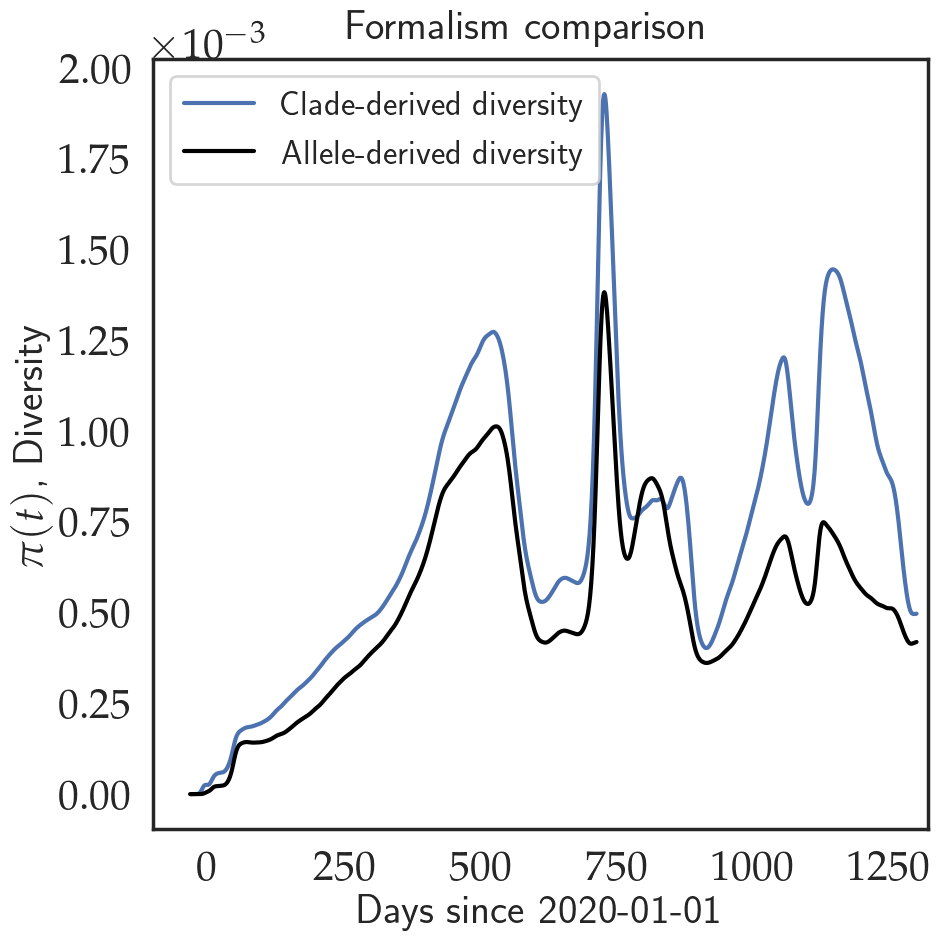

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.lineplot(data = average_diversity.query('day_diff < 1300'),
    x = 'day_diff',
    y = 'total_diversity',
    # hue = 'Pango_Variant',
    ax = ax, legend= False, lw = 3, label = 'Clade-derived diversity')

ax.plot(total_day_diffs[total_day_diffs < 1300], total_div_arr[total_day_diffs < 1300]/2, color = 'black', lw = 3, label = 'Allele-derived diversity')
ax.legend(fontsize = 25, loc = 'upper left')
ax.set_xlabel('Days since 2020-01-01', fontsize = 30)
ax.set_ylabel('$\pi(t)$, Diversity', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.suptitle('Formalism comparison', fontsize = 30, y = .93)    
ax.set_xlim(-100,1320)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
offset_text = ax.yaxis.get_offset_text()
offset_text.set_fontsize(30)
offset_text.set_position((offset_text.get_position()[0], offset_text.get_position()[1] + 2.3))
thesis_picture_folder = os.path.relpath("../../Thesis/figures/2_chapter/")
# plt.savefig(thesis_picture_folder + '/formalism_comparison.pdf', bbox_inches = 'tight')
